# Causal Effect

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.16.2', '0.24.2', '0.11.1', '1.2.0']


## Utility function
We define a utility function to draw the directed acyclic graph.

In [2]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

## Test data
We use 'Auto MPG Data Set' (http://archive.ics.uci.edu/ml/datasets/Auto+MPG) 

In [3]:
X = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original',
                   delim_whitespace=True, header=None,
                   names = ['mpg', 'cylinders', 'displacement',
                            'horsepower', 'weight', 'acceleration',
                            'model year', 'origin', 'car name'])
X.dropna(inplace=True)
X.drop(['model year', 'origin', 'car name'], axis=1, inplace=True)
print(X.shape)
X.head()

(392, 6)


,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8.0,307.0,130.0,3504.0,12.0
1,15.0,8.0,350.0,165.0,3693.0,11.5
2,18.0,8.0,318.0,150.0,3436.0,11.0
3,16.0,8.0,304.0,150.0,3433.0,12.0
4,17.0,8.0,302.0,140.0,3449.0,10.5


## Causal Discovery
To run causal discovery, we create a `DirectLiNGAM` object and call the `fit` method.

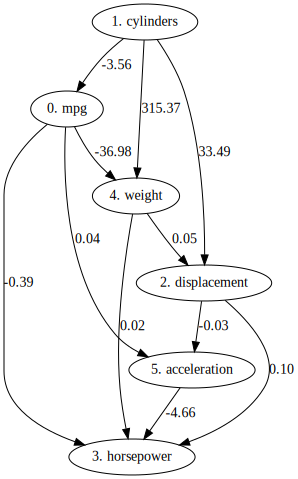

In [4]:
model = lingam.DirectLiNGAM()
model.fit(X)
labels = [f'{i}. {col}' for i, col in enumerate(X.columns)]
make_graph(model.adjacency_matrix_, labels)

## Prediction Model
We create the linear regression model.

In [5]:
from sklearn.linear_model import LinearRegression

target = 0 # mpg
features = [i for i in range(X.shape[1]) if i != target]
reg = LinearRegression()
reg.fit(X.iloc[:, features], X.iloc[:, target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Identification of Feature with Greatest Causal Influence on Prediction
To identify of the feature having the greatest intervention effect on the prediction, we create a `CausalEffect` object and call the `estimate_effects_on_prediction` method. 

In [6]:
ce = lingam.CausalEffect(model)
effects = ce.estimate_effects_on_prediction(X, target, reg)

df_effects = pd.DataFrame()
df_effects['feature'] = X.columns
df_effects['effect_plus'] = effects[:, 0]
df_effects['effect_minus'] = effects[:, 1]
df_effects

,feature,effect_plus,effect_minus
0,mpg,1.937266,1.937266
1,cylinders,5.998015,5.998015
2,displacement,1.056742,1.056742
3,horsepower,1.739774,1.739774
4,weight,5.110672,5.110672
5,acceleration,0.501212,0.501212


In [7]:
max_index = np.unravel_index(np.argmax(effects), effects.shape)
print(X.columns[max_index[0]])

cylinders


## Estimation of Optimal Intervention
To estimate of the intervention such that the expectation of the prediction of the post-intervention observations is equal or close to a specified value, we use `estimate_optimal_intervention` method of `CausalEffect`.

In [8]:
# mpg = 15
c = ce.estimate_optimal_intervention(X, target, reg, 1, 15)
print(f'Optimal intervention: {c:.3f}')

Optimal intervention: 7.871


In [9]:
# mpg = 21
c = ce.estimate_optimal_intervention(X, target, reg, 1, 21)
print(f'Optimal intervention: {c:.3f}')

Optimal intervention: 6.167


In [10]:
# mpg = 30
c = ce.estimate_optimal_intervention(X, target, reg, 1, 30)
print(f'Optimal intervention: {c:.3f}')

Optimal intervention: 3.610
